[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [22]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [23]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [26]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy-3"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [27]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

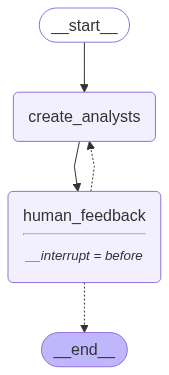

In [28]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [29]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Print the event
    print("\n\n" + "=" * 50)
    print(event)
    print("-" * 50)
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  



{'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3}
--------------------------------------------------


{'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Adoption Specialist', description='Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.'), Analyst(affiliation='Data Security Solutions', name='Mr. Raj Patel', role='Cybersecurity Analyst', description='Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assess

In [30]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [31]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup AC/VC to add an investor perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0580fe-f213-6243-8002-a0c948522b06'}}

In [32]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Print the event
    print("\n\n" + "=" * 50)
    print(event)
    print("-" * 50)    
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 



{'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analysts': 3, 'human_analyst_feedback': 'Add in someone from a startup AC/VC to add an investor perspective', 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Adoption Specialist', description='Dr. Carter focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes, improve efficiency, and provide a competitive edge to organizations. Her analysis often includes case studies and data-driven insights to support the adoption of innovative frameworks.'), Analyst(affiliation='Data Security Solutions', name='Mr. Raj Patel', role='Cybersecurity Analyst', description='Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His focus is on evaluating the security features of LangGraph, assessing potential vulnerabilities, and ensuring th

In [33]:
# Display the state
state = graph.get_state(thread)
state.values

{'topic': 'The benefits of adopting LangGraph as an agent framework',
 'max_analysts': 3,
 'human_analyst_feedback': 'Add in someone from a startup AC/VC to add an investor perspective',
 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Analyst', description='Dr. Emily Carter focuses on the technical advantages and innovations brought by adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph can enhance system performance, scalability, and integration capabilities. She is particularly concerned with the technical feasibility and the potential for LangGraph to streamline complex processes in software development.'),
  Analyst(affiliation='GreenTech Solutions', name='Michael Thompson', role='Sustainability Analyst', description='Michael Thompson evaluates the environmental and sustainability benefits of adopting LangGraph. His analysis centers on how LangGraph can contribute to reducing energy consumption and

In [34]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f058100-4862-6e5a-8004-eb68d4890d2f'}}

In [35]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [36]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [37]:
final_state.next

()

In [38]:
final_state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f058100-4862-6e5a-8004-eb68d4890d2f'}}

In [56]:
final_state.metadata

{'source': 'update', 'step': 4, 'parents': {}, 'thread_id': '1'}

In [39]:
final_state.values

{'topic': 'The benefits of adopting LangGraph as an agent framework',
 'max_analysts': 3,
 'human_analyst_feedback': None,
 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Analyst', description='Dr. Emily Carter focuses on the technical advantages and innovations brought by adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph can enhance system performance, scalability, and integration capabilities. She is particularly concerned with the technical feasibility and the potential for LangGraph to streamline complex processes in software development.'),
  Analyst(affiliation='GreenTech Solutions', name='Michael Thompson', role='Sustainability Analyst', description='Michael Thompson evaluates the environmental and sustainability benefits of adopting LangGraph. His analysis centers on how LangGraph can contribute to reducing energy consumption and improving resource efficiency in tech operations. He is motivat

In [40]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Analyst
Description: Dr. Emily Carter focuses on the technical advantages and innovations brought by adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph can enhance system performance, scalability, and integration capabilities. She is particularly concerned with the technical feasibility and the potential for LangGraph to streamline complex processes in software development.
--------------------------------------------------
Name: Michael Thompson
Affiliation: GreenTech Solutions
Role: Sustainability Analyst
Description: Michael Thompson evaluates the environmental and sustainability benefits of adopting LangGraph. His analysis centers on how LangGraph can contribute to reducing energy consumption and improving resource efficiency in tech operations. He is motivated by the potential for LangGraph to support sustainable development goals and reduce the carbon footprint of technolog

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [41]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [42]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def ask_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [43]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [44]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [45]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

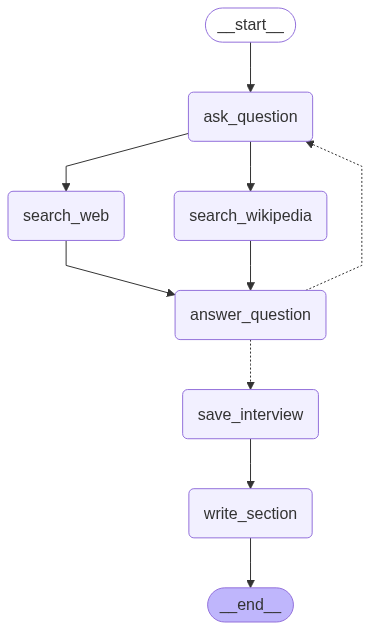

In [62]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
Your goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def answer_question(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2], [3], ...) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[1] https://ai.meta.com/blog/meta-llama-3-1/
[2] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[1] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(
        content=f"""
Use the following source and interview to write your section.
The source is enclosed with <source> tag and the interview is enclosed with <interview> tag.
<source>{context}</source>\n\n---\n\n<interview>{interview}</interview>""")]) 
    
    print(section.content)

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", ask_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", answer_question)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [47]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Analyst', description='Dr. Emily Carter focuses on the technical advantages and innovations brought by adopting LangGraph as an agent framework. Her primary interest lies in how LangGraph can enhance system performance, scalability, and integration capabilities. She is particularly concerned with the technical feasibility and the potential for LangGraph to streamline complex processes in software development.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [48]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing Agent Frameworks for Enhanced System Performance

### Summary

In the rapidly evolving landscape of software development, the need for robust frameworks that can handle complex processes efficiently is paramount. LangGraph emerges as a groundbreaking agent framework that offers significant technical advantages over traditional solutions. Unlike Directed Acyclic Graph (DAG)-based frameworks, LangGraph supports cyclical workflows, which are essential for implementing agent-like behaviors. This capability allows developers to create sophisticated agents that can iteratively refine their understanding and actions, leading to more capable AI systems [1][2].

One of the most compelling features of LangGraph is its ability to enhance system performance through fine-grained control over application flow and state. This is achieved by allowing developers to manage complex agent interactions more effectively, thereby improving system quality and reducing development

## LangGraph: Revolutionizing Agent Frameworks for Enhanced System Performance

### Summary

In the rapidly evolving landscape of software development, the need for robust frameworks that can handle complex processes efficiently is paramount. LangGraph emerges as a groundbreaking agent framework that offers significant technical advantages over traditional solutions. Unlike Directed Acyclic Graph (DAG)-based frameworks, LangGraph supports cyclical workflows, which are essential for implementing agent-like behaviors. This capability allows developers to create sophisticated agents that can iteratively refine their understanding and actions, leading to more capable AI systems [1][2].

One of the most compelling features of LangGraph is its ability to enhance system performance through fine-grained control over application flow and state. This is achieved by allowing developers to manage complex agent interactions more effectively, thereby improving system quality and reducing development time. The framework's built-in persistence feature supports advanced memory and cumulative loop functions, further contributing to its robustness [3].

For organizations and developers aiming to build complex agent systems or applications requiring stateful, iterative processing, LangGraph provides a solid foundation. However, it is crucial to assess whether the additional complexity of LangGraph is justified for simpler applications, as its capabilities are best suited for scenarios that demand such advanced features [2].

A notable example of LangGraph's cyclical workflow capability is its application in developing a debate system between two agents. In this system, a user poses a question, and two agents‚Äîone optimistic and one skeptical‚Äîdebate the topic. A judge agent evaluates the arguments and determines the best answer to return to the user. LangGraph's support for cycles allows these agents to loop through their tasks, evaluate outcomes, and adapt dynamically based on the debate's progress and the judge's evaluation [4]. This cyclical capability streamlines the process by enabling continuous refinement and decision-making, which would be challenging to implement with traditional DAG-based frameworks [5].

In summary, LangGraph stands out as a versatile and powerful framework that can significantly enhance system performance, scalability, and integration capabilities. Its innovative approach to cyclical workflows and state management makes it an ideal choice for developers looking to streamline complex processes in software development.

### Sources
[1] https://medium.com/primastat/building-agentic-applications-with-langgraph-part-1-tabular-ocr-agent-6ba81a6c0862  
[2] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[3] https://arize.com/blog/langgraph/  
[4] https://www.metriccoders.com/post/langgraph-building-stateful-multi-agent-workflows-with-langchain  
[5] https://blog.spheron.network/build-smarter-ai-agents-in-minutes-with-langgraph  

In [49]:
interview['sections']

["## LangGraph: Revolutionizing Agent Frameworks for Enhanced System Performance\n\n### Summary\n\nIn the rapidly evolving landscape of software development, the need for robust frameworks that can handle complex processes efficiently is paramount. LangGraph emerges as a groundbreaking agent framework that offers significant technical advantages over traditional solutions. Unlike Directed Acyclic Graph (DAG)-based frameworks, LangGraph supports cyclical workflows, which are essential for implementing agent-like behaviors. This capability allows developers to create sophisticated agents that can iteratively refine their understanding and actions, leading to more capable AI systems [1][2].\n\nOne of the most compelling features of LangGraph is its ability to enhance system performance through fine-grained control over application flow and state. This is achieved by allowing developers to manage complex agent interactions more effectively, thereby improving system quality and reducing dev

In [52]:
interview

{'messages': [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='159b4564-2223-43a0-ab09-50815d09e13c'),
  AIMessage(content="Hello, I'm Alex Thompson, a fellow technology enthusiast and writer. I'm eager to learn more about the technical advantages and innovations that LangGraph brings to the table. Dr. Carter, could you start by explaining what makes LangGraph stand out in terms of enhancing system performance compared to other agent frameworks?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 263, 'total_tokens': 322, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id'

In [53]:
len(interview['sections'])

1

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [54]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    ### GenerateAnalystsState - at the top of the graph for the analysts ###
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    ### InterviewState - in the middle of the graph for the interview ###
    sections: Annotated[list, operator.add] # Send() API key
    ### Global State - in the bottom of the graph for the final report ###
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

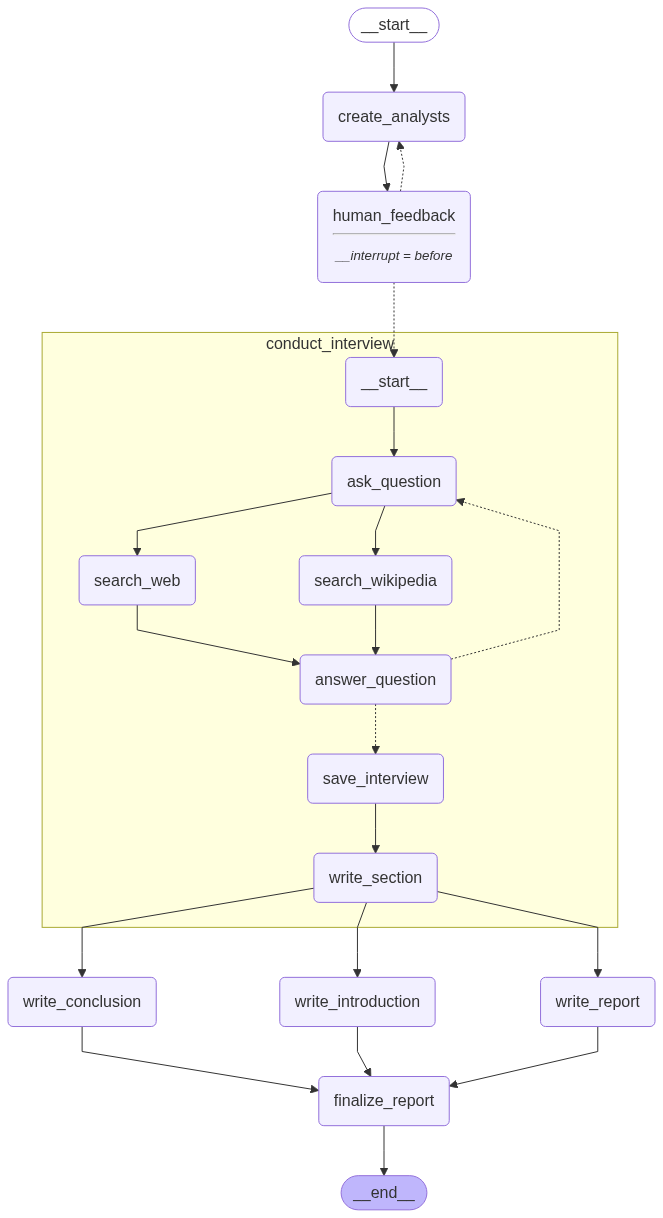

In [55]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n---\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [66]:
# Inputs
max_analysts = 5 
# topic = "The benefits of adopting LangGraph as an agent framework"
topic = "The differences between AI translation and AI localization using AI Tools as an agent framework"
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Global Linguistics Institute
Role: Linguistic Specialist
Description: Dr. Chen focuses on the linguistic nuances and challenges in AI translation versus localization. She is particularly interested in how AI tools handle idiomatic expressions and cultural context, and the implications for accuracy and user satisfaction.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: AI Technology Developer
Description: Raj is a developer specializing in AI tools for language processing. His primary concern is the technological advancements and limitations in AI translation and localization, including the integration of machine learning algorithms to improve contextual understanding.
--------------------------------------------------
Name: Sofia Martinez
Affiliation: Cultural Insights Group
Role: Cultural Analyst
Description: Sofia examines the cultural implications of AI localization. She is focused on how AI 

In [67]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in someone from a startup AC/VC to add an investor perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f058155-84ed-686f-8002-a4b304217c93'}}

In [68]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Global Linguistics Institute
Role: Linguistic Specialist
Description: Dr. Chen focuses on the linguistic nuances and challenges in AI translation versus localization. She is particularly interested in how AI tools handle idiomatic expressions and cultural context, and the implications for accuracy and user satisfaction.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: AI Technology Developer
Description: Raj is a developer specializing in AI tools for language processing. His primary concern is the technological advancements and limitations in AI translation and localization, including the integration of machine learning algorithms to improve contextual understanding.
--------------------------------------------------
Name: Sofia Martinez
Affiliation: Cultural Insights Group
Role: Cultural Analyst
Description: Sofia examines the cultural implications of AI localization. She is focused on how AI 

In [69]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f058156-5f46-6316-8004-5e3554a0c176'}}

In [70]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

## Bridging Cultures: The Role of AI in Translation and Localization

### Summary

In the rapidly evolving landscape of artificial intelligence, the distinction between AI translation and AI localization is becoming increasingly significant. Dr. Tran's exploration into this domain highlights the critical role AI plays in maintaining the integrity of meaning across different languages and cultures. While AI translation focuses on converting text from one language to another with grammatical accuracy, AI localization delves deeper, ensuring that content is culturally relevant and resonates with the target audience.

AI translation tools, such as those integrated into translation management systems like XTM Cloud, are designed to enhance translation workflows by automating processes, thereby reducing costs and time to market without compromising quality [1]. These tools primarily aim to maintain the accuracy of the original message while ensuring grammatical correctness in the target lang

In [71]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# AI Translation vs. AI Localization: Bridging Language and Culture

## Introduction

In the dynamic realm of artificial intelligence, the distinction between AI translation and AI localization is pivotal for businesses aiming to engage global audiences. This report delves into the nuances of these processes, highlighting AI translation's focus on linguistic accuracy and AI localization's emphasis on cultural relevance. We explore the strategic benefits of AI tools, such as enhanced efficiency and cost-effectiveness, and their role in avoiding cultural faux pas. Through real-world examples and insights from industry experts, we illustrate how AI-driven strategies can unlock new markets and foster meaningful connections across diverse cultural landscapes.

---



In the rapidly evolving landscape of artificial intelligence, the distinction between AI translation and AI localization is becoming increasingly significant. AI translation primarily focuses on converting text from one language to another with grammatical accuracy, leveraging advanced algorithms like neural networks to understand context, meaning, and structure [1]. This capability allows for swift and efficient translation processes, which are crucial in our globalized world. Tools integrated into translation management systems, such as XTM Cloud, enhance translation workflows by automating processes, thereby reducing costs and time to market without compromising quality [1].

AI localization, however, extends beyond mere translation. It involves the cultural adaptation of content, ensuring that it resonates with the target audience by aligning with local customs and preferences. This process includes translating text and adapting images, symbols, and other cultural references to fit the local context, ensuring that the content is not only linguistically accurate but also culturally relevant [2][3]. AI localization tools integrate artificial intelligence into the entire localization process, helping to avoid cultural faux pas and ensuring cultural sensitivity [3][4].

A novel aspect of AI in this domain is the use of AI tools as an agent framework. These tools automate workflows, manage translation priorities, and conduct quality assurance checks, delivering human-like translations that are accurate, on-brand, and context-specific. AI agents in localization can assume roles such as Strategic Localization Advisor, Real-Time Content Orchestrator, and Quality Management Partner. This multi-agent framework enhances efficiency, reduces costs, and accelerates market entry, while maintaining brand voice and ensuring contextual adaptation [2][3].

Real-world examples, such as Amazon's expansion into non-English speaking countries, demonstrate the transformative potential of AI-powered localization. By employing advanced AI and machine learning tools, Amazon has successfully localized its vast product catalog, tailoring descriptions, customer reviews, and service communications to new regions. This strategy not only enhances customer experience but also fosters trust and engagement in new markets [4].

The collaboration between AI and human linguists is crucial, as AI handles routine translations with speed and consistency, while humans focus on creative refinement for content requiring emotional resonance or cultural sensitivity [2][3]. This approach not only enhances the quality of localized content but also ensures its cultural relevance, making it a key element in the responsible integration of AI into the global market [1][2].

In conclusion, while AI translation focuses on linguistic accuracy, AI localization encompasses a broader scope, ensuring cultural appropriateness and relevance in addition to linguistic correctness. The integration of AI tools enhances both processes, offering a cutting-edge solution for businesses seeking to expand globally. These advancements not only improve the efficiency and accuracy of translation and localization but also present lucrative investment opportunities, making global outreach more feasible for businesses of all sizes.


---

## Conclusion

In the rapidly evolving landscape of artificial intelligence, the distinction between AI translation and AI localization is crucial for businesses aiming to engage effectively with global audiences. AI translation focuses on linguistic accuracy, converting text efficiently across languages, while AI localization ensures cultural relevance by adapting content to fit local norms and expectations. The integration of AI tools as an agent framework enhances both processes, automating workflows and ensuring quality. Real-world examples, such as Amazon's successful market expansions, highlight the transformative potential of AI localization. Ultimately, these advancements offer strategic benefits, enabling businesses to unlock global markets with efficiency and cultural sensitivity.

## Sources
[1] https://lokalise.com/blog/how-ai-translation-works/  
[2] https://www.oneskyapp.com/blog/ai-agents-localization/  
[3] https://bayan-tech.com/blog/ai-localization/  
[4] https://medium.com/@jesse.henson/launching-products-in-new-markets-with-ai-powered-localization-73f07ab7f3b4

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r